In [1]:
import seaborn as sns
import os
import pandas as pd
import numpy as np
import shutil
import warnings
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision
import sklearn.metrics as metrics
from PIL import Image
import torch.nn.functional as F


criterion = nn.CrossEntropyLoss()

In [3]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [4]:
path0 = '../../dataset/Stanford_chestxray_dataset/'
path = '../../dataset/Stanford_chestxray_dataset/CheXpert-v1.0-small/'
os.listdir(path)

['train.csv', 'train', 'valid.csv', 'valid']

In [5]:
path1 = path + 'train.csv'
df = pd.read_csv(path1)
df.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
3         Lateral   NaN         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           NaN          NaN    NaN            NaN        NaN          NaN   
1           1.0          NaN   -1.0           -1.0        NaN         -1.0   
2           1.0          NaN    NaN           -1.0        NaN          NaN   
3           1.0          NaN    NaN           -1.0        NaN          NaN   
4           NaN          NaN    1.0            NaN        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               NaN            NaN       NaN              1.0  
1           NaN              -1.0            NaN       1.0              NaN  
2           NaN               NaN            NaN       1.0              NaN  
3           NaN               NaN            NaN       1.0              NaN  
4           0.0               NaN            NaN       NaN              NaN

In [6]:
mapping = {'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Pleural Effusion': 3, 'No Finding': 4, 'Pneumothorax': 5}
disease_labels = {j:i for i,j in mapping.items()}
diseases = ['Consolidation','Cardiomegaly','No Finding','Pleural Effusion','Pneumothorax','Atelectasis']
disease_labels

{0: 'Atelectasis',
 1: 'Cardiomegaly',
 2: 'Consolidation',
 3: 'Pleural Effusion',
 4: 'No Finding',
 5: 'Pneumothorax'}

In [7]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="4"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
!nvidia-htop.py

Sun Feb 27 15:40:51 2022
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   24C    P8     8W / 250W |      0MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 26%   60C    

In [9]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [13]:
from collections import defaultdict

def Evaluate(model):
    count = defaultdict(lambda: 0)
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    preds = []
    pred_labels = []
    labels = []
    with torch.no_grad():
        for i in range(150,len(df)):
            if df['Frontal/Lateral'][i]=="Lateral":
                continue
            for j in diseases:
                if count[j]<5 and df[j][i]==1.0:
                    image = pil_loader(path0+df['Path'][i])
                    plt.axis('off')
                    plt.imshow(image)
                    plt.show()
                    plt.clf()
                    x = data_transforms['test'](image)
                    x = torch.Tensor(np.expand_dims(x,axis = 0))
                    x = x.to(device)
                    valid_logits = model(x)
                    predict_prob = F.softmax(valid_logits)

                    _,predictions = predict_prob.max(1)
                    predictions = predictions.to('cpu')
                    prediction = int(predictions[0])
                    if df[disease_labels[prediction]][i] and df[disease_labels[prediction]][i]== 1:
                        print('correct',disease_labels[prediction])
                        running_corrects += 1
                        count[disease_labels[prediction]]+=1
                    print('prediction:',disease_labels[prediction], 'actual:', j)
                    labels.append(mapping[j])
                    predict_prob = predict_prob.to('cpu')

                    pred_labels.extend(list(predictions.numpy()))
                    preds.extend(list(predict_prob.numpy()))
                    total += 1
                    break
            if i>=380:
                break
        print('Accuracy:',running_corrects/total)
        return(preds, pred_labels,labels)

def ROC_plot(y_probas,labels):
    for c in range(6):
        fpr = []
        tpr = []
        thresholds = np.arange(0.0, 1.01, .01)

        P = list(labels).count(c)
        N = len(labels) - P

        for thresh in thresholds:
            FP=0
            TP=0
            for i in range(len(labels)):
                if (y_probas[i][c] > thresh):
                    if labels[i] == c:
                        TP = TP + 1
                    else:
                        FP = FP + 1
            fpr.append(FP/float(N))
            tpr.append(TP/float(P))
            
        auc = np.trapz(tpr,fpr)
        plt.plot(fpr, tpr, label = 'Class: {}, auc:{:.2f}'.format(c,auc))
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.show()

# Squeezenet

In [14]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)

squeezenet.features[3].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[3].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[4].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[4].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[5].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[5].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[7].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[7].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[8].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[8].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[9].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[9].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[10].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[10].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.features[12].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[12].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.classifier = nn.Sequential(
                                        nn.Dropout(0.5),
                                        nn.Conv2d(512, 6, kernel_size=(1, 1), stride=(1, 1)),
                                        nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

model = squeezenet

model.load_state_dict(torch.load('New/saved5/exlnet1.pt'))
model = model.to(device)

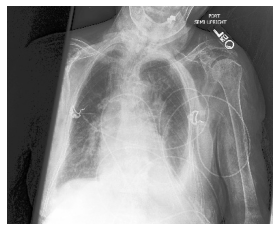

prediction: Pleural Effusion actual: Atelectasis


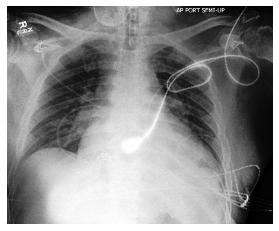

correct Cardiomegaly
prediction: Cardiomegaly actual: Cardiomegaly


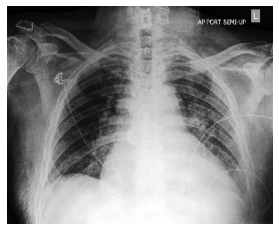

prediction: Pleural Effusion actual: Cardiomegaly


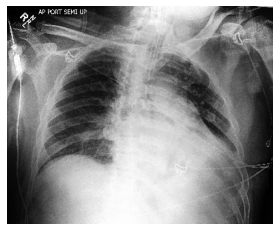

prediction: Pleural Effusion actual: Cardiomegaly


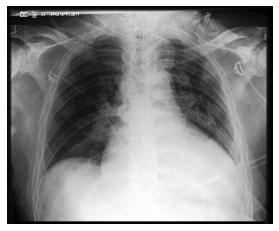

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


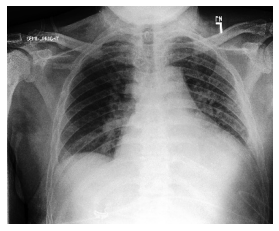

correct Pleural Effusion
prediction: Pleural Effusion actual: Pleural Effusion


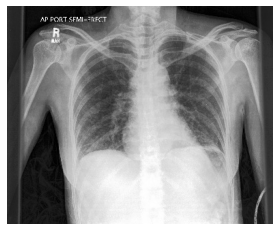

prediction: No Finding actual: Pneumothorax


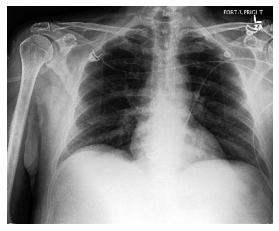

correct No Finding
prediction: No Finding actual: No Finding


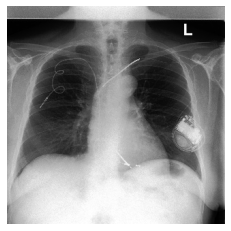

correct No Finding
prediction: No Finding actual: No Finding


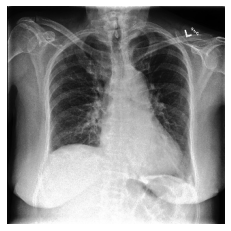

correct Pleural Effusion
prediction: Pleural Effusion actual: Pleural Effusion


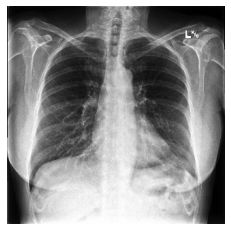

correct No Finding
prediction: No Finding actual: No Finding


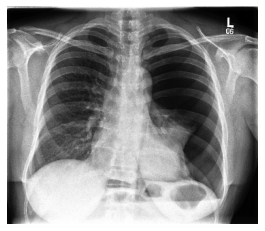

prediction: Atelectasis actual: Pneumothorax


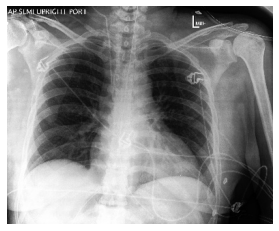

correct No Finding
prediction: No Finding actual: No Finding


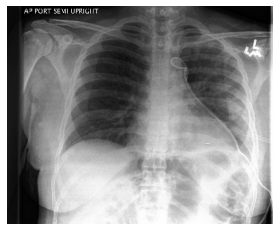

correct Pneumothorax
prediction: Pneumothorax actual: Pneumothorax


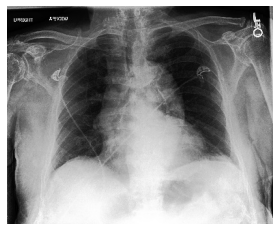

correct Atelectasis
prediction: Atelectasis actual: Atelectasis


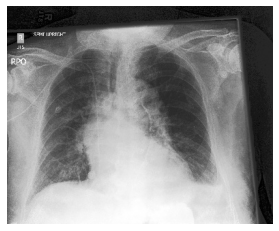

prediction: Atelectasis actual: Cardiomegaly


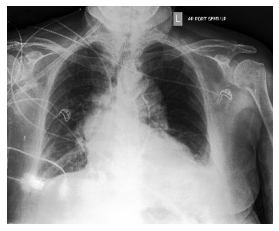

correct Pleural Effusion
prediction: Pleural Effusion actual: Pleural Effusion


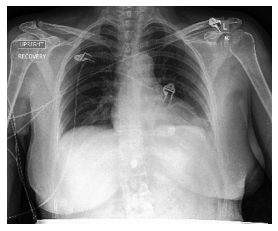

prediction: Atelectasis actual: No Finding


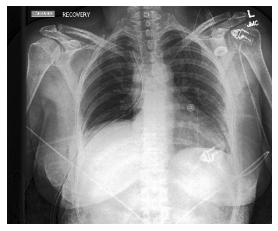

prediction: Pneumothorax actual: No Finding


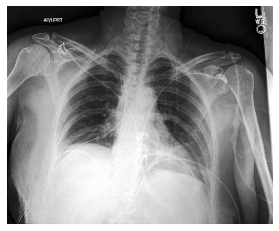

correct Pleural Effusion
prediction: Pleural Effusion actual: Pleural Effusion


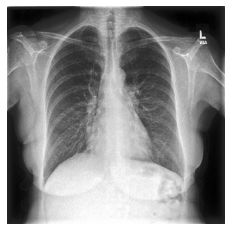

prediction: Atelectasis actual: No Finding


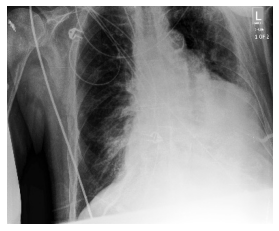

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


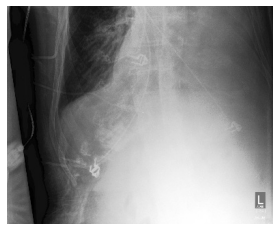

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


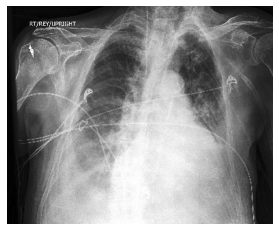

correct Pleural Effusion
prediction: Pleural Effusion actual: Consolidation


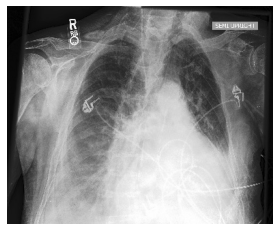

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


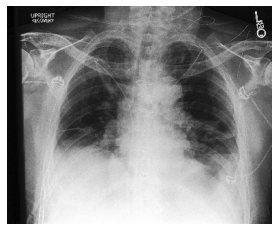

correct Pleural Effusion
prediction: Pleural Effusion actual: Atelectasis


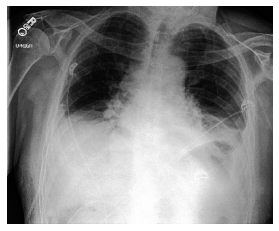

correct Atelectasis
prediction: Atelectasis actual: Atelectasis


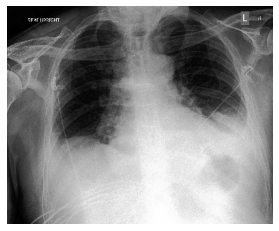

correct Pleural Effusion
prediction: Pleural Effusion actual: Consolidation


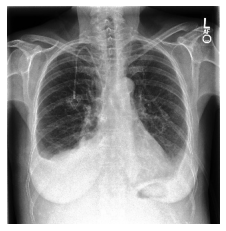

correct Pleural Effusion
prediction: Pleural Effusion actual: Consolidation


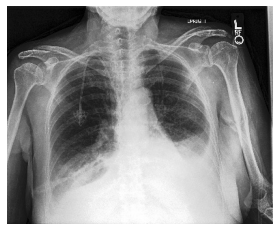

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


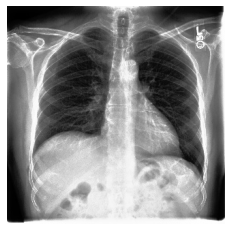

prediction: Atelectasis actual: No Finding


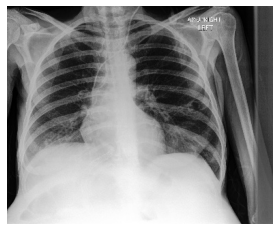

prediction: No Finding actual: Consolidation


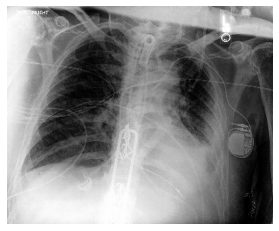

prediction: No Finding actual: Consolidation


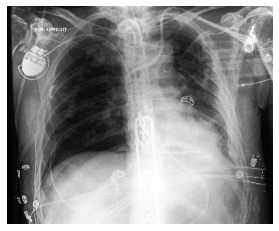

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


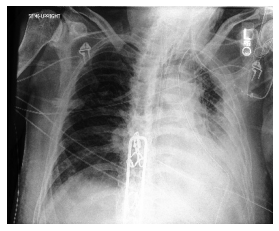

correct Pleural Effusion
prediction: Pleural Effusion actual: Atelectasis


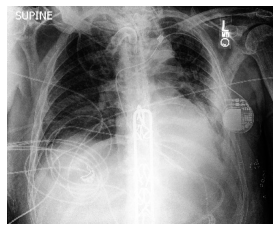

correct Pleural Effusion
prediction: Pleural Effusion actual: Consolidation


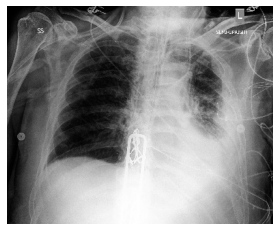

correct Pleural Effusion
prediction: Pleural Effusion actual: Atelectasis


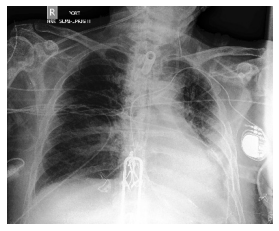

correct Pleural Effusion
prediction: Pleural Effusion actual: Consolidation


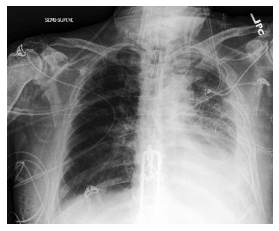

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


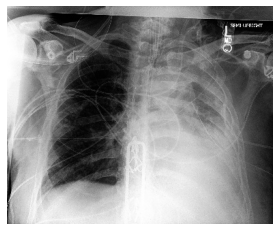

correct Pleural Effusion
prediction: Pleural Effusion actual: Pneumothorax


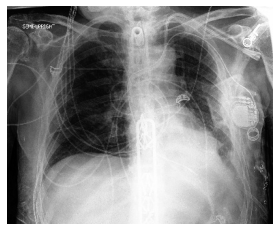

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


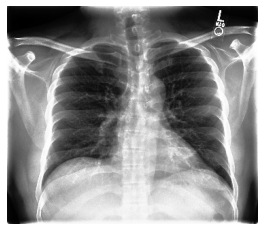

prediction: Atelectasis actual: No Finding


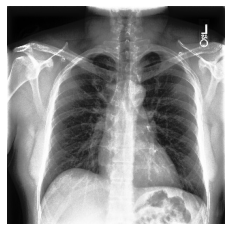

correct No Finding
prediction: No Finding actual: No Finding


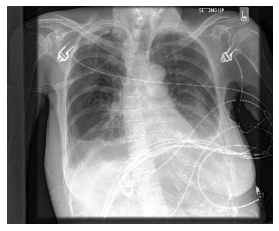

correct Pleural Effusion
prediction: Pleural Effusion actual: Consolidation


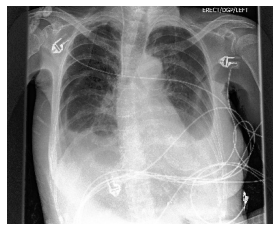

prediction: Pneumothorax actual: Consolidation


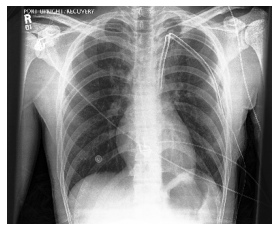

prediction: No Finding actual: Pneumothorax


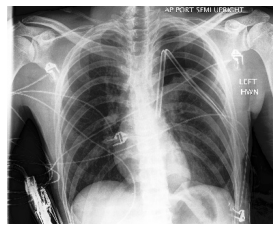

prediction: Pleural Effusion actual: Pneumothorax


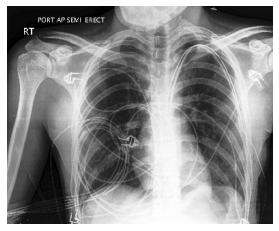

correct Pneumothorax
prediction: Pneumothorax actual: Pneumothorax


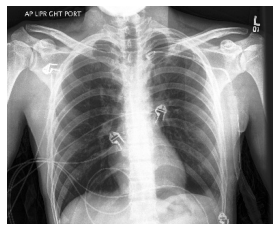

correct Pneumothorax
prediction: Pneumothorax actual: Pneumothorax


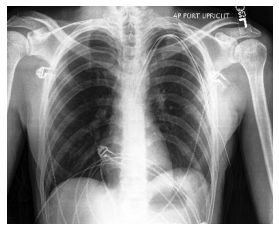

correct Pneumothorax
prediction: Pneumothorax actual: Pneumothorax


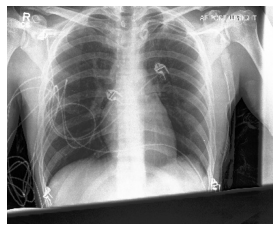

prediction: No Finding actual: Pneumothorax


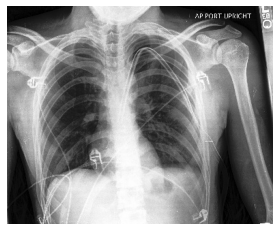

correct Pneumothorax
prediction: Pneumothorax actual: Pneumothorax


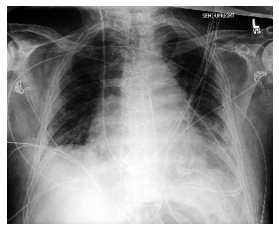

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


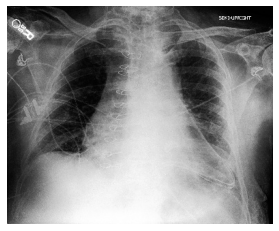

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


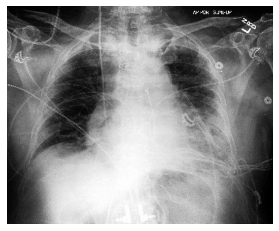

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


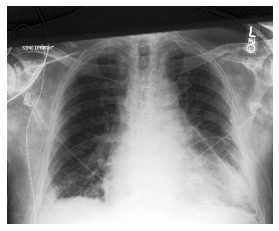

prediction: Atelectasis actual: Cardiomegaly


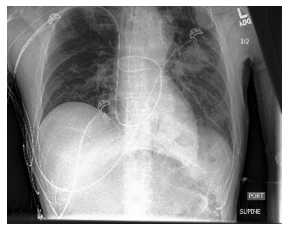

prediction: Atelectasis actual: Consolidation


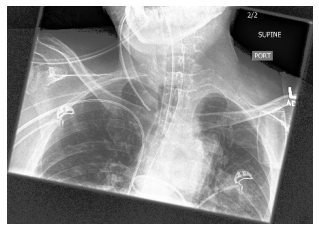

prediction: Pleural Effusion actual: Consolidation


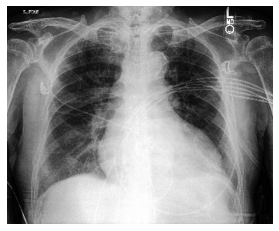

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly


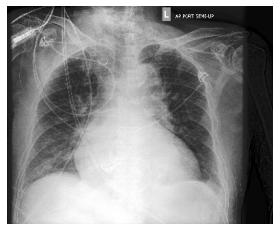

prediction: Pleural Effusion actual: Cardiomegaly


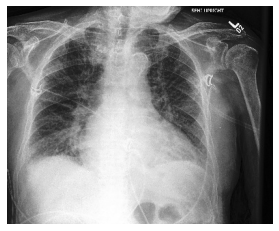

prediction: Pleural Effusion actual: Cardiomegaly


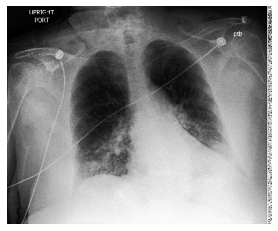

prediction: Pleural Effusion actual: Consolidation


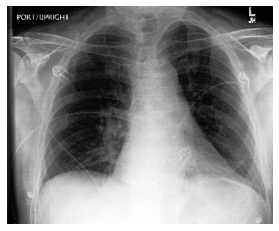

prediction: Atelectasis actual: Cardiomegaly


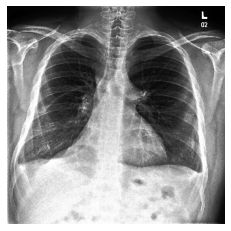

prediction: Pleural Effusion actual: Atelectasis


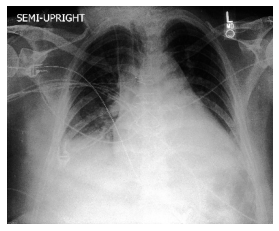

correct Atelectasis
prediction: Atelectasis actual: Atelectasis


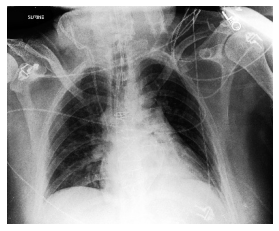

correct Pleural Effusion
prediction: Pleural Effusion actual: Atelectasis


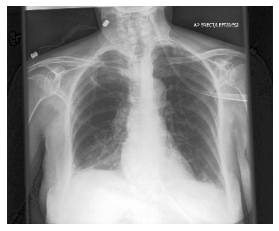

prediction: Pleural Effusion actual: Consolidation


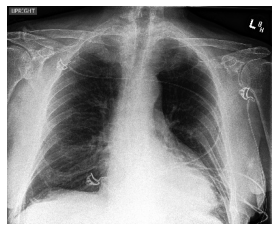

prediction: Atelectasis actual: Consolidation


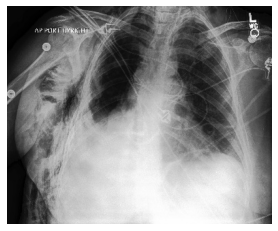

prediction: Pleural Effusion actual: Atelectasis


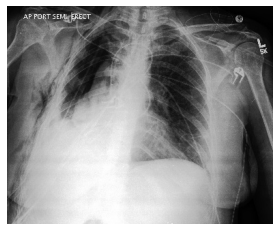

correct Atelectasis
prediction: Atelectasis actual: Atelectasis


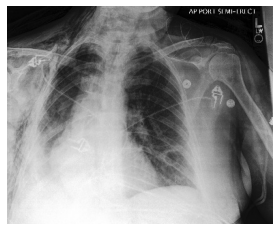

correct Pneumothorax
prediction: Pneumothorax actual: Atelectasis


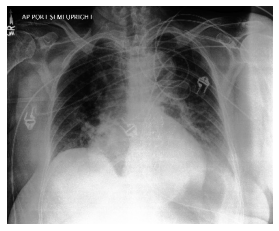

prediction: Pneumothorax actual: Consolidation


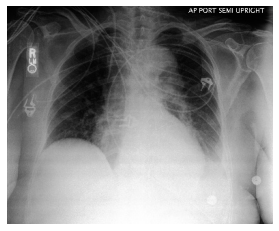

correct Atelectasis
prediction: Atelectasis actual: Atelectasis


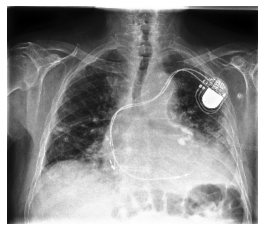

correct Pleural Effusion
prediction: Pleural Effusion actual: Cardiomegaly
Accuracy: 0.6081081081081081


<Figure size 432x288 with 0 Axes>

In [15]:
preds, pred_labels,labels = Evaluate(model)

In [18]:
print(metrics.precision_recall_fscore_support(np.array(labels), np.array(pred_labels)))

(array([0.        , 0.5       , 0.        , 0.57142857, 0.58333333,
       0.        ]), array([0.        , 0.2       , 0.        , 0.75      , 0.77777778,
       0.        ]), array([0.        , 0.28571429, 0.        , 0.64864865, 0.66666667,
       0.        ]), array([ 1,  5,  3, 16,  9,  7]))


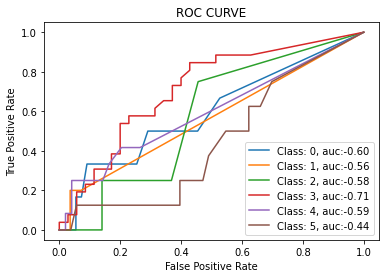

In [15]:
ROC_plot(preds,labels)

In [16]:
print(metrics.classification_report(labels,pred_labels))

              precision    recall  f1-score   support

           0       0.22      0.33      0.27         6
           1       0.00      0.00      0.00         5
           2       0.10      0.25      0.14         4
           3       0.65      0.50      0.57        26
           4       0.50      0.17      0.25        12
           5       0.06      0.12      0.08         8

    accuracy                           0.31        61
   macro avg       0.26      0.23      0.22        61
weighted avg       0.41      0.31      0.34        61

